# CLASIFICACIÓN
Desarrollar un modelo que clasifique el nivel de obesidad de un individuo en una de las siguientes categorías: Bajo peso, Peso normal, Sobrepeso, Obesidad

## Regresión Logística Multinominal

In [71]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

### Carga y análisis de datos

In [72]:
# Cargamos el CSV en un DataFrame
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

# Analisis exploratorio de los datos (EDA)
# print(df.info())
# print(df.describe())
# profile = ProfileReport(df)
# profile.to_file("obesidad.html")

# Longitud de los valores únicos de las variables para localizar las categóricas
for col in df.columns:
    print(f"{col}: {df[col].unique()}")
    print(f"{col}: {len(df[col].unique())}")

categoricas = ['family_history_with_overweight',  'CAEC', 'CALC', 'MTRANS', 'NObeyesdad']
binarias = ['Gender', 'FAVC', 'SMOKE' , 'SCC']

Gender: ['Female' 'Male']
Gender: 2
Age: [21 23 27 22 29 24 26 41 30 52 20 19 31 39 17 25 55 38 18 15 61 44 34 36
 32 35 40 45 33 51 56 28 16 37 14 42 43 46 48 47]
Age: 40
Height: [1.62 1.52 1.8  1.78 1.5  1.64 1.72 1.85 1.65 1.77 1.7  1.93 1.53 1.71
 1.69 1.6  1.75 1.68 1.58 1.79 1.56 1.67 1.66 1.81 1.82 1.55 1.61 1.63
 1.76 1.57 1.88 1.87 1.89 1.74 1.83 1.92 1.73 1.84 1.91 1.48 1.59 1.54
 1.9  1.86 1.45 1.98 1.51 1.46 1.49 1.95 1.94]
Height: 51
Weight: [ 64.    56.    77.   ... 131.41 133.69 133.35]
Weight: 1335
family_history_with_overweight: ['yes' 'no']
family_history_with_overweight: 2
FAVC: ['no' 'yes']
FAVC: 2
FCVC: [2.   3.   1.   2.45 2.88 2.01 2.6  2.59 2.39 1.12 2.03 2.66 2.89 2.71
 2.75 1.49 2.21 2.06 2.31 2.82 2.05 2.77 2.74 2.57 2.52 2.97 1.08 1.27
 1.34 2.96 2.73 2.84 2.44 2.43 2.93 2.02 1.03 1.59 1.21 1.52 2.7  2.36
 2.14 2.56 2.34 1.81 2.72 1.13 1.76 2.98 2.2  2.53 2.24 2.65 2.9  2.48
 2.95 2.78 1.01 2.94 1.89 1.95 2.28 2.37 2.32 2.62 1.05 2.76 2.07 2.69
 2.79 2.67 1.

### Conclusión del EDA
-   No se han encontrado valores nulos
-   No se aprecian valores atípicos los cuales no sean representativos
-   El dataset cuenta con con algunas filas duplicadas (0.4%)
-   ``Gender`` está altamamente correlacionada con ``Height`` y ``NObeyesdad``
-   ``Height`` está altamamente correlacionada con ``Gender``
-   ``NObeyesdad`` está altamamente correlacionada con ``Gender``, ``Weigth`` y ``family_history_with_overweight``
-   ``Weigth`` está altamamente correlacionada con ``NObeyesdad`` y ``family_history_with_overweight``
-   ``family_history_with_overweight`` está altamamente correlacionada con ``NObeyesdad`` y  ``Weigth``

### Limpieza de datos

In [73]:
# Eliminación de duplicados
print("Registros antes de eliminar duplicados: \n", df.count())
df = df.drop_duplicates()
print("Registros después de eliminar duplicados: \n", df.count())


Registros antes de eliminar duplicados: 
 Gender                            2111
Age                               2111
Height                            2111
Weight                            2111
family_history_with_overweight    2111
FAVC                              2111
FCVC                              2111
NCP                               2111
CAEC                              2111
SMOKE                             2111
CH2O                              2111
SCC                               2111
FAF                               2111
TUE                               2111
CALC                              2111
MTRANS                            2111
NObeyesdad                        2111
dtype: int64
Registros después de eliminar duplicados: 
 Gender                            2087
Age                               2087
Height                            2087
Weight                            2087
family_history_with_overweight    2087
FAVC                              2087
FCVC

In [74]:
# Creación de la columna IMC
df["IMC"] = df["Weight"] / (df["Height"] ** 2)

# Mapeo de la columna IMC para aplicar modelo de clasificación
df["IMC"] = np.where(df["IMC"] < 18.5, "Bajo peso",
            np.where(df["IMC"] <= 24.9, "Peso normal",
            np.where(df["IMC"] <= 29.9, "Sobrepeso", "Obesidad")))

# Conteo de los valores de IMC
df["IMC"].value_counts()

IMC
Obesidad       977
Sobrepeso      552
Peso normal    293
Bajo peso      265
Name: count, dtype: int64

### Preprocesamiento y división de los datos


In [75]:
# Encodeamiento de las variables categóricas
for col in categoricas:
    df_encodeado = pd.get_dummies(df[col], drop_first=True)
    df = pd.concat([df, df_encodeado], axis=1)
df = df.drop(columns=categoricas)
print(df.info())

df["Gender"] = df["Gender"].map({'Male' : 0, 'Female' : 1})
df["FAVC"] = df["FAVC"].map({'no' : 0, 'yes' : 1})
df["SCC"] = df["SCC"].map({'no' : 0, 'yes' : 1})
df["SMOKE"] = df["SMOKE"].map({'no' : 0, 'yes' : 1})
print(df)

# Definimos las variables predictoras y objetivo
X = df.drop(columns=["IMC"])
y = df["IMC"]

# Escalamiento de las variables numéricas
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(f"Tamaño de X_scaled: {X.shape}, Tamaño de y: {y.shape}") # Asegurar que X e y tienen el mismo número de filas

# División de datos entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 2087 entries, 0 to 2110
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 2087 non-null   object 
 1   Age                    2087 non-null   int64  
 2   Height                 2087 non-null   float64
 3   Weight                 2087 non-null   float64
 4   FAVC                   2087 non-null   object 
 5   FCVC                   2087 non-null   float64
 6   NCP                    2087 non-null   float64
 7   SMOKE                  2087 non-null   object 
 8   CH2O                   2087 non-null   float64
 9   SCC                    2087 non-null   object 
 10  FAF                    2087 non-null   float64
 11  TUE                    2087 non-null   float64
 12  IMC                    2087 non-null   object 
 13  yes                    2087 non-null   bool   
 14  Frequently             2087 non-null   bool   
 15  Sometimes

### Entrenamiento del modelo


Resultados con Sobremuestreo Aleatorio:
Accuracy: 98.80%
Precision: 98.26%
Recall: 98.25%
F1-Score: 98.25%
AUC-ROC: 99.40%

Resultados con SMOTE:
Accuracy: 98.80%
Precision: 98.26%
Recall: 98.25%
F1-Score: 98.25%
AUC-ROC: 99.07%

Resultados con Submuestreo Aleatorio:
Accuracy: 98.80%
Precision: 98.26%
Recall: 98.25%
F1-Score: 98.25%
AUC-ROC: 99.06%

Resultados con NearMiss:
Accuracy: 98.33%
Precision: 97.47%
Recall: 97.76%
F1-Score: 97.61%
AUC-ROC: 98.98%

El mejor método de balanceo es: Sobremuestreo Aleatorio con F1-Score: 98.25% y AUC-ROC: 99.40%

Resultados con ajuste manual de hiperparámetros:
Accuracy: 98.80%
Precision: 98.26%
Recall: 98.25%
F1-Score: 98.25%
AUC-ROC: 99.40%

Resultados con ajuste automático de hiperparámetros:
Mejores parámetros: {'C': 100, 'solver': 'lbfgs'}
Mejor Accuracy en validación cruzada: 99.46%
Accuracy: 98.33%
Precision: 97.31%
Recall: 97.76%
F1-Score: 97.53%
AUC-ROC: 99.74%
              precision    recall  f1-score   support

   Bajo peso       0.95

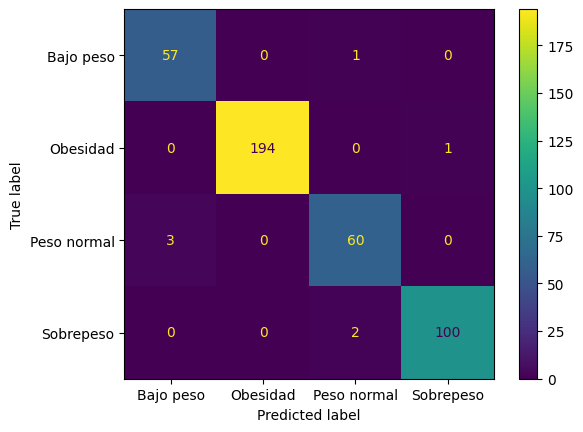

In [76]:
# --------------------
# MÉTODOS DE BALANCEO DE CLASES
# --------------------
# 1. Sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# 2. SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 3. Submuestreo aleatorio
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# 4. NearMiss (submuestreo basado en distancia)
nearmiss = NearMiss()
X_train_nm, y_train_nm = nearmiss.fit_resample(X_train, y_train)

# --------------------
# EVALUACIÓN DE MÉTODOS DE BALANCEO
# --------------------wha
resultados_balanceo = {}

def evaluar_balanceo(X_train_resampled, y_train_resampled, metodo):
    # Creación del modelo de RL
    model = LogisticRegression(C=0.1, solver='liblinear', max_iter=500)
    # Entreno el modelo con los datos de cada modelo
    model.fit(X_train_resampled, y_train_resampled)
    # Realizo predicciones con el modelo
    y_pred = model.predict(X_test)
    # Calculo la precisión del modelo sacando las métricas
    f1 = f1_score(y_test, y_pred, average='macro') * 100
    auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr') * 100
    resultados_balanceo[metodo] = (f1, auc)
    # Imprimimos los resultados
    print(f"\nResultados con {metodo}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(f"Precision: {precision_score(y_test, y_pred, average='macro') * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro') * 100:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"AUC-ROC: {auc:.2f}%")

evaluar_balanceo(X_train_ros, y_train_ros, "Sobremuestreo Aleatorio")
evaluar_balanceo(X_train_smote, y_train_smote, "SMOTE")
evaluar_balanceo(X_train_rus, y_train_rus, "Submuestreo Aleatorio")
evaluar_balanceo(X_train_nm, y_train_nm, "NearMiss")

# Seleccionar el mejor método de balanceo
mejor_metodo = max(resultados_balanceo, key=lambda k: resultados_balanceo[k])
print(f"\nEl mejor método de balanceo es: {mejor_metodo} con F1-Score: {resultados_balanceo[mejor_metodo][0]:.2f}% y AUC-ROC: {resultados_balanceo[mejor_metodo][1]:.2f}%")

# Obtener los datos balanceados del mejor método encontrado
if mejor_metodo == "Sobremuestreo Aleatorio":
    X_train_resampled, y_train_resampled = X_train_ros, y_train_ros
elif mejor_metodo == "SMOTE":
    X_train_resampled, y_train_resampled = X_train_smote, y_train_smote
elif mejor_metodo == "Submuestreo Aleatorio":
    X_train_resampled, y_train_resampled = X_train_rus, y_train_rus
elif mejor_metodo == "NearMiss":
    X_train_resampled, y_train_resampled = X_train_nm, y_train_nm

# --------------------
# MÉTODO 1: Ajuste manual de hiperparámetros
# --------------------
manual_model = LogisticRegression(C=0.1, solver='liblinear', max_iter=500)  # Ejemplo de hiperparámetros ajustados manualmente
manual_model.fit(X_train_resampled, y_train_resampled)  # Entrenar modelo

# Predicciones
y_pred_manual = manual_model.predict(X_test)

# Evaluación del modelo ajustado manualmente
print("\nResultados con ajuste manual de hiperparámetros:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_manual) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_manual, average='macro') * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_manual, average='macro') * 100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_manual, average='macro') * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(y_test, manual_model.predict_proba(X_test), multi_class='ovr') * 100:.2f}%")

# --------------------
# MÉTODO 2: Ajuste automático con GridSearchCV
# --------------------
parametros = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Diferentes valores de regularización
    "solver": ["liblinear", "lbfgs"]  # Diferentes algoritmos de optimización
}

# Configurar GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=500), parametros, cv=5, scoring="accuracy", n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)  # Entrenar búsqueda de hiperparámetros

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predicciones del mejor modelo
y_pred_best = best_model.predict(X_test)

# Evaluación del mejor modelo
print("\nResultados con ajuste automático de hiperparámetros:")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor Accuracy en validación cruzada: {grid_search.best_score_ * 100:.2f}%")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_best, average='macro') * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_best, average='macro') * 100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_best, average='macro') * 100:.2f}%")
print(f"AUC-ROC: {roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr') * 100:.2f}%")


# --------------------
# ENTRENAMIENTO FINAL Y EVALUACIÓN
# --------------------

# Entrenar el mejor modelo con los datos balanceados
best_model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones finales con el mejor modelo y el mejor balanceo
y_pred_final = best_model.predict(X_test)

# Mostramos el reporte de la clasificación
print(classification_report(y_test, y_pred_final))

# Matriz de confusión
matrix = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()


### Análisis del resultado de la regresión logística
-   Resultados con ajuste automático de hiperparámetros:
    - Mejores parámetros: {'C': 100, 'solver': 'lbfgs'}
    - Mejor Accuracy en validación cruzada: 99.46%
    - Accuracy: 98.33%
    - Precision: 97.31%
    - Recall: 97.76%
    - F1-Score: 97.53%
    - AUC-ROC: 99.74%

- Una vez aplicados los métodos de balanceo de clases observamos que el que mejor resultados posee es **Sobremuestreo Aleatorio** con F1-Score: 98.25% y AUC-ROC: 99.40%
- El modelo sobrepasa con creces el 80% en las diferentes métricas de evaluación por lo que es un buen modelo en todas ellas.
- La matriz de confusión muestra una gran capacidad de diferenciación entre clases.
- **Conclusión**: Muy buen modelo.

## Árbol de decisión

In [77]:
# Importar librerías necesarias
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import tree

### Entrenamiento del modelo
Se realiza directamente esta parte debido a que la carga, limpieza y preprocesamiento de los datos se ha realizado para el modelo anterior y este modelo puede trabajar perfectamente con dichas métricas.<br>

Accuracy: 97.13%
Precision: 95.62%
Recall: 96.04%
F1-Score: 95.77%
AUC-ROC: 97.59%


[Text(0.76611328125, 0.9583333333333334, 'x[3] <= 0.231\ngini = 0.673\nsamples = 1669\nvalue = [207.0, 782.0, 230.0, 450.0]'),
 Text(0.5947265625, 0.875, 'x[23] <= 1.067\ngini = 0.707\nsamples = 1012\nvalue = [207, 148, 230, 427]'),
 Text(0.680419921875, 0.9166666666666667, 'True  '),
 Text(0.376953125, 0.7916666666666666, 'x[3] <= -1.023\ngini = 0.608\nsamples = 791\nvalue = [205, 148, 12, 426]'),
 Text(0.15625, 0.7083333333333334, 'x[27] <= 1.086\ngini = 0.116\nsamples = 213\nvalue = [200.0, 0.0, 7.0, 6.0]'),
 Text(0.10416666666666667, 0.625, 'x[28] <= 1.044\ngini = 0.029\nsamples = 203\nvalue = [200, 0, 2, 1]'),
 Text(0.08333333333333333, 0.5416666666666666, 'x[3] <= -1.039\ngini = 0.02\nsamples = 202\nvalue = [200, 0, 2, 0]'),
 Text(0.041666666666666664, 0.4583333333333333, 'x[3] <= -1.217\ngini = 0.01\nsamples = 194\nvalue = [193, 0, 1, 0]'),
 Text(0.020833333333333332, 0.375, 'gini = 0.0\nsamples = 159\nvalue = [159, 0, 0, 0]'),
 Text(0.0625, 0.375, 'x[10] <= -0.132\ngini = 0.056

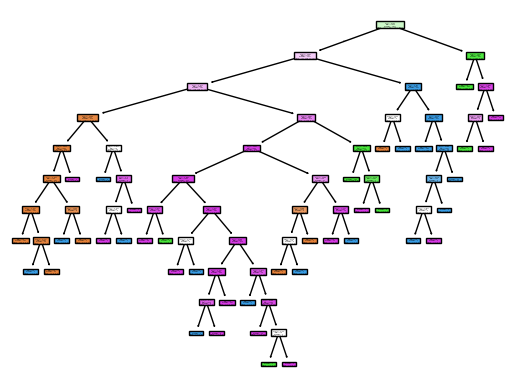

In [79]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
# Calculo la precisión del modelo sacando las métricas
f1 = f1_score(y_test, y_pred, average='macro') * 100
auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr') * 100
# Imprimimos los resultados
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred, average='macro') * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, average='macro') * 100:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print(f"AUC-ROC: {auc:.2f}%")

# Visualizar el árbol de decisión
tree.plot_tree(model, filled=True)

Observamos que sin optimizar la búsqueda de hiperparámetros obtenemos los siguientes valores en las métricas:
-   Accuracy: 97.13%
-   Precision: 95.62%
-   Recall: 96.04%
-   F1-Score: 95.77%
-   AUC-ROC: 97.59%

Estos son valores bastante buenos que superan el 80% estipulado para que se considere buen modelo, vamos a realizar una búsqueda de hiperparámetros con GridSearch para ver si podemos mejorar estos valores.

In [80]:
# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el clasificador de árbol de decisión
model = DecisionTreeClassifier(random_state=42)

# Definir el grid de parámetros
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'splitter' : ['best', 'random']
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo con los parámetros especificados
grid_search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# Evaluar el modelo en el conjunto de prueba
accuracy = grid_search.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")

Mejores parámetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy en el conjunto de prueba: 0.9880


Una vez obtenidos los mejores hiperparámetros procedemos a definir un modelo con los mismos.

Accuracy: 98.80%
Precision: 98.26%
Recall: 98.25%
F1-Score: 98.25%
AUC-ROC: 98.90%


[Text(0.7170138888888888, 0.9545454545454546, 'x[23] <= 0.011\ngini = 0.673\nsamples = 1669\nvalue = [207.0, 782.0, 230.0, 450.0]'),
 Text(0.5081018518518519, 0.8636363636363636, 'x[28] <= 1.692\ngini = 0.592\nsamples = 1448\nvalue = [205.0, 782.0, 12.0, 449.0]'),
 Text(0.6125578703703703, 0.9090909090909092, 'True  '),
 Text(0.29398148148148145, 0.7727272727272727, 'x[27] <= 2.199\ngini = 0.526\nsamples = 1207\nvalue = [205.0, 777.0, 12.0, 213.0]'),
 Text(0.125, 0.6818181818181818, 'x[12] <= -1.633\ngini = 0.336\nsamples = 986\nvalue = [205, 777, 3, 1]'),
 Text(0.05555555555555555, 0.5909090909090909, 'x[3] <= -0.872\ngini = 0.079\nsamples = 121\nvalue = [116, 5, 0, 0]'),
 Text(0.037037037037037035, 0.5, 'gini = 0.0\nsamples = 116\nvalue = [116, 0, 0, 0]'),
 Text(0.07407407407407407, 0.5, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0, 0]'),
 Text(0.19444444444444445, 0.5909090909090909, 'x[6] <= 0.65\ngini = 0.193\nsamples = 865\nvalue = [89, 772, 3, 1]'),
 Text(0.1111111111111111, 0.5, 

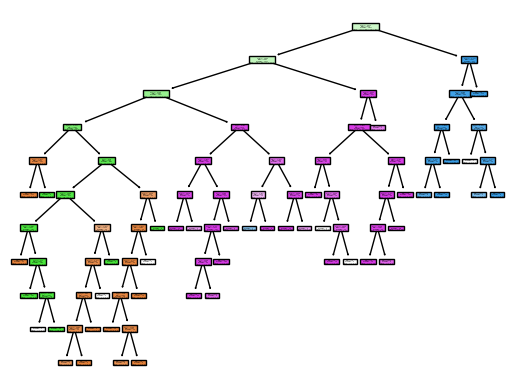

In [81]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter='random')

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
# Calculo la precisión del modelo sacando las métricas
f1 = f1_score(y_test, y_pred, average='macro') * 100
auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr') * 100
# Imprimimos los resultados
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred, average='macro') * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, average='macro') * 100:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print(f"AUC-ROC: {auc:.2f}%")

# Visualizar el árbol de decisión
tree.plot_tree(model, filled=True)

### Analisis final de árbol de decisión
Optimizando los hiperparámetros obtenemos las siguientes métricas:
-   Accuracy: 98.80%
-   Precision: 98.26%
-   Recall: 98.25%
-   F1-Score: 98.25%
-   AUC-ROC: 98.90%

Hemos mejorado los resultados respecto al siguiente entrenamiento.
<br>
Mediante estas métricas podemos determinar que este modelo de arbol de decisión es muy preciso.

# Conclusión final: selección de modelo
- Métricas de la regresión logística:
    ```
    - Accuracy: 98.33%
    - Precision: 97.31%
    - Recall: 97.76%
    - F1-Score: 97.53%
    - AUC-ROC: 99.74%
    ```

- Métricas del árbol de decisión:
    ```
    -  Accuracy: 98.80%
    -  Precision: 98.26%
    -  Recall: 98.25%
    -  F1-Score: 98.25%
    -  AUC-ROC: 98.90%
    -  Media: 
    ```

Interpretando los resultados de ambos modelos podemos determinar que ambos nos predicen de manera muy parecida, pero el árbol de decisión tiene un margen de acierto minimamente superior a la regresión logística. <br>
**Mejor modelo**: Árbol de decisión